In [1]:
%matplotlib notebook
import numpy as np

import matplotlib.pyplot as plt
from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF
import multiprocessing
from scipy.spatial import cKDTree
import dask
import dask.array as da
from discretize.utils import closestPoints
from SimPEG.Utils import mkvc
import zarr
from zarr import empty

In [3]:
from dask.distributed import Client
client = Client()
client

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\distributed\bokeh\core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


<Client: scheduler='tcp://127.0.0.1:57623' processes=8 cores=8>

Tiled Inversion Demo
=================

In this notebook, we demonstrate how to use run a tiled inversion. The forward sub-problems are computed on TreeMesh but the inversion is done on a TensoMesh

First we create a base tensor mesh, model.

<IPython.core.display.Javascript object>


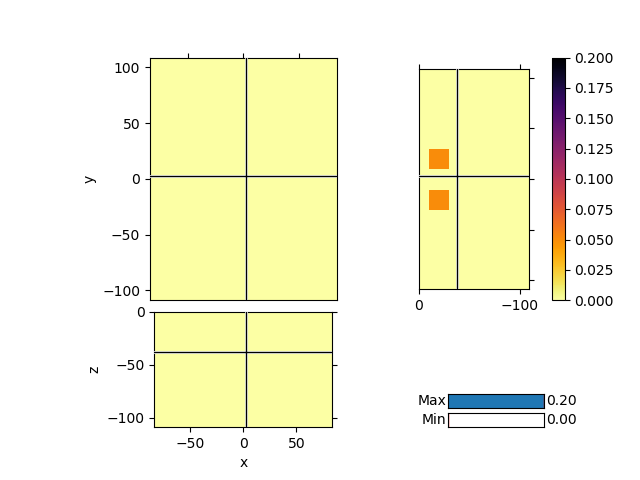

In [4]:
H0 = (50000, 90, 0)

# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 10), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 20), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh.x0 = mesh.x0 - np.r_[0,0,mesh.gridN[-1,2]]

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
# [xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
# zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-1]

# We would usually load a topofile
# topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
# actv = Utils.surface2ind_topo(mesh, topo, 'N')
# actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
#                   dtype=int) - 1
actv = np.ones(mesh.nC, dtype='bool')

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-22.5, 22.5, 10)
yr = np.linspace(-32.5, 32.5, 10)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X)*mesh.vectorNz[-1] + 5. #-np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1] + 5.

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rx = PF.BaseMag.RxObs(rxLoc)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField)

# We can now create a susceptibility model and generate data
model = np.zeros(mesh.nC)

# Add a block in half-space
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[-10,-30,-30], np.r_[10,-10,-10], 0.05)
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[-10,10,-30], np.r_[10,30,-10], 0.05)
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[50,50,-30], np.r_[120,120,-10], 0.2)

model = Utils.mkvc(model)
model = model[actv]


mesh.plot3DSlicer(model, aspect="equal", pcolorOpts={"cmap":'inferno_r'}, transparent='slider')


Forward model 
============

Create a MAG survey and compute data

In [5]:
import os 
cwd = os.getcwd()

Begin forward: M=H0, Rx type= tmi
dask.array<concatenate, shape=(100, 9000), dtype=float64, chunksize=(1, 9000)>


<IPython.core.display.Javascript object>


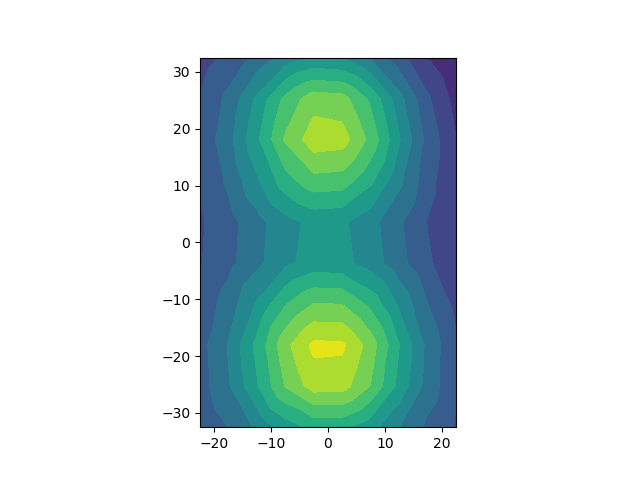

(<matplotlib.contour.QuadContourSet at 0x28e318c6b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28e2f8efe10>)

In [6]:


# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv, path=cwd)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
data = d + np.random.randn(len(d))
wd = np.ones(len(data))*1.  # Assign flat uncertainties

survey.dobs = data
survey.std = wd
survey.mtrue = model

# Plot the data
rxLoc = survey.srcField.rxList[0].locs
Utils.plot2Ddata(rxLoc, d)

In [6]:
prob.G

dask.array<zarr, shape=(100, 9000), dtype=float64, chunksize=(20, 9000)>

# Divide the problem in sub meshes

Next step, we create sub-problems: one mesh+problem / observation

In [ ]:


# Create a mesh template
h = [5., 5., 5.]
padDist = np.ones((3,2)) * 200
wr = np.zeros(actv.sum())

dmis = []

tree = cKDTree(mesh.gridCC[actv, :])

@dask.delayed
def makeSubProblem(args):
    globalMesh, globalActive, globalSurvey, globalTree, ind, h, padDist = args

    rxLoc = globalSurvey.srcField.rxList[0].locs

    loc = np.c_[rxLoc[ind, :]].T
    rx = PF.BaseMag.RxObs(loc)

    srcField = PF.BaseMag.SrcField([rx], param=globalSurvey.srcField.param)
    survey_t = PF.BaseMag.LinearSurvey(srcField)
    survey_t.dobs = np.c_[globalSurvey.dobs[ind]]
    survey_t.std = np.c_[globalSurvey.std[ind]]
    survey_t.index = ind

    # Create a mesh

    # Keep same fine cells as global
    h = [globalMesh.hx.min(), globalMesh.hy.min(), globalMesh.hz.min()]


    mesh_t = Utils.modelutils.meshBuilder(
        rxLoc, h, padDist, meshType='TREE', meshGlobal=globalMesh,
        verticalAlignment='center'
    )

    # Refine the mesh around loc
    mesh_t = Utils.modelutils.refineTree(
        mesh_t, loc, dtype='point',
        nCpad=[3, 3, 3], finalize=True
    )
    actv_t = np.ones(mesh_t.nC, dtype='bool')

    # Create reduced identity map
    tileMap = Maps.Tile((globalMesh, globalActive), (mesh_t, actv_t))
    tileMap._tree = globalTree

    # Create the forward model operator
    prob_t = PF.Magnetics.MagneticIntegral(
            mesh_t, chiMap=tileMap, actInd=actv_t,
            verbose=False)

    survey_t.pair(prob_t)

    # Pre-calc sensitivities and projections
    prob_t.G
    tileMap.P

    # Data misfit function
    dmis = DataMisfit.l2_DataMisfit(survey_t, eps=survey_t.std)
    dmis.W = 1./survey_t.std

    return dmis

# pool = multiprocessing.Pool(4)

# result = pool.map(makeSubProblem, [rxLoc[ii, :] for ii in range(rxLoc.shape[0])])
# pool.close()
# pool.join()

# LOOP over the points and generate problems
objfcts = {}
for ii in range(rxLoc.shape[0]):

    objfcts[ii] = makeSubProblem((mesh, actv, survey, tree, ii, h, padDist))

job = dask.compute(objfcts, num_workers=8)




In [6]:
print("Computing sensitivity cell_weights")
wr = np.zeros(nC)
# for key, value in d.items()
for ii, objfct in job[0].items():

    if ii == 0:
        globalMisfit = objfct
        
    else:
        globalMisfit += objfct
    wr += mkvc((objfct.prob.G*objfct.prob.chiMap.deriv(None))**2.)

wr /= wr.max()
wr **= 0.5

Computing sensitivity cell_weights


# Inversion

Build the usual inversion and run

In [7]:


# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
# reg.norms = [0, 1, 1, 1]
# reg.eps_p, reg.eps_q = 1e-3, 1e-3


# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(globalMisfit, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.71e+09  2.50e+05  0.00e+00  2.50e+05    7.64e+01      0              
   1  1.36e+09  2.15e+05  5.35e-06  2.22e+05    7.78e+01      0              
   2  6.78e+08  1.91e+05  1.77e-05  2.03e+05    7.61e+01      0   Skip BFGS  
   3  3.39e+08  1.58e+05  5.16e-05  1.76e+05    7.53e+01      0   Skip BFGS  
   4  1.69e+08  1.22e+05  1.27e-04  1.43e+05    7.45e+01      0   Skip BFGS  
   5  8.47e+07  8.86e+04  2.65e-04  1.11e+05    7.30e+01      0   Skip BFGS  
   6  4.23e+07  6.16e+04  4.93e-04  8.25e+04    7.13e+01      0   Skip BFGS  
   7  2.12e+07  3.94e+04  8.69e-04  5.78e+04    6.98e+01      0   Skip BFGS  
   8

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:937: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


  18  1.03e+04  3.58e+01  4.60e-03  8.34e+01    7.71e+01      0              
  19  2.07e+04  1.31e+01  4.60e-03  1.08e+02    6.42e+01      1   Skip BFGS  
  20  4.14e+04  1.07e+01  4.67e-03  2.04e+02    5.47e+01      0   Skip BFGS  
delta phim: 3.286e-02
  21  8.27e+04  1.07e+01  4.65e-03  3.95e+02    5.17e+01      1              
  22  1.65e+05  1.46e+01  4.57e-03  7.71e+02    6.32e+01      2              
  23  3.31e+05  2.24e+01  4.50e-03  1.51e+03    4.50e+01      1              
delta phim: 9.010e-02
  24  6.62e+05  2.31e+01  4.50e-03  3.00e+03    4.33e+01      7   Skip BFGS  
  25  4.96e+05  2.03e+02  4.13e-03  2.25e+03    5.16e+01      0              
  26  3.72e+05  1.18e+02  4.26e-03  1.70e+03    7.40e+01      0              
delta phim: 1.180e-01
  27  2.79e+05  7.35e+01  4.34e-03  1.29e+03    7.45e+01      0              
  28  2.09e+05  6.74e+01  4.33e-03  9.75e+02    6.32e+01      4   Skip BFGS  
  29  2.09e+05  5.44e+01  4.38e-03  9.71e+02    5.37e+01      1   Skip BFGS 

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


  37  3.10e+05  4.65e+01  4.39e-03  1.41e+03    6.85e+01     19   Skip BFGS  


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


  38  3.10e+05  4.65e+01  4.39e-03  1.41e+03    5.26e+01      5              


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


delta phim: 4.714e-04
Minimum decrease in regularization.End of IRLS
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.4997e+04
1 : |xc-x_last| = 2.7746e-04 <= tolX*(1+|x0|) = 1.0095e-01
0 : |proj(x-g)-x|    = 5.2592e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 5.2592e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     39
------------------------- DONE! -------------------------


<IPython.core.display.Javascript object>


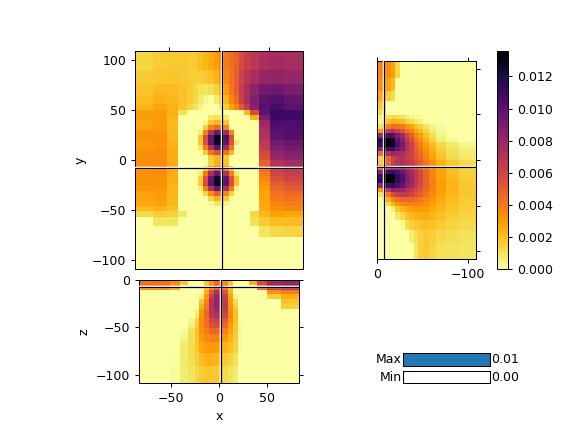

In [23]:
mesh.plot3DSlicer(mrec, aspect="equal", pcolorOpts={"cmap":'inferno_r'}, transparent='slider')


In [8]:
dpred = np.zeros(survey.nD)
for ind, dmis in enumerate(globalMisfit.objfcts):
    dpred[dmis.survey.index] += dmis.survey.dpred(mrec)

In [9]:
ax = plt.subplot(1,3,1)
Utils.plot2Ddata(rxLoc, d, ax=ax)

ax = plt.subplot(1,3,2)
Utils.plot2Ddata(rxLoc, dpred, ax=ax)

ax = plt.subplot(1,3,3)
Utils.plot2Ddata(rxLoc, d-dpred, ax=ax)



(<matplotlib.contour.QuadContourSet at 0x1abbed047b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1abbecc8240>)

# Run single mesh

Re-run the problem in one shot for comparison

In [8]:
# from dask.dot import dot_graph
# dot_graph(F.dask)

In [ ]:
import time
import dask.array as da

start = time.time()
wr = np.array(da.sum(prob.G**2., axis=0))**0.5
wr /= wr.max()

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr

# Create misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = np.ones(survey.nD)

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrecSingle = inv.run(m0)

print("Total CPU time:" + str(time.time()-start))

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.52e+09  2.51e+05  0.00e+00  2.51e+05    7.61e+01      0              
   1  1.26e+09  2.15e+05  6.18e-06  2.23e+05    7.81e+01      0              
   2  6.30e+08  1.90e+05  2.07e-05  2.03e+05    7.59e+01      0   Skip BFGS  
   3  3.15e+08  1.57e+05  5.94e-05  1.76e+05    7.51e+01      0   Skip BFGS  
   4  1.57e+08  1.20e+05  1.45e-04  1.42e+05    7.42e+01      0   Skip BFGS  
   5  7.87e+07  8.59e+04  2.98e-04  1.09e+05    7.29e+01      0   Skip BFGS  
   6  3.93e+07  5.85e+04  5.46e-04  8.00e+04    7.10e+01      0   Skip BFGS  
   7  1.9

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:937: RuntimeWarning: invalid value encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


delta phim:    nan
  15  7.68e+04  2.31e+01  4.52e-03  3.71e+02    6.79e+01      0   Skip BFGS  
delta phim: 6.424e-02
  16  1.54e+05  1.03e+01  4.62e-03  7.20e+02    5.98e+01      0   Skip BFGS  
delta phim: 4.915e-02
  17  3.07e+05  1.12e+01  4.61e-03  1.43e+03    4.87e+01      4              
delta phim: 4.910e-03
  18  2.31e+05  7.14e+01  4.36e-03  1.08e+03    5.01e+01      0              
delta phim: 1.129e-01
  19  1.90e+05  6.07e+01  4.39e-03  8.95e+02    7.18e+01      1              
delta phim: 1.444e-02
  20  3.80e+05  2.48e+01  4.50e-03  1.73e+03    4.57e+01      0              
delta phim: 4.310e-02
  21  6.64e+05  2.86e+01  4.48e-03  3.00e+03    4.84e+01      5   Skip BFGS  
delta phim: 6.199e-03
  22  4.98e+05  1.72e+02  4.17e-03  2.25e+03    4.96e+01      0              
delta phim: 1.334e-01
  23  3.73e+05  1.49e+02  4.21e-03  1.72e+03    6.96e+01      1              
delta phim: 1.745e-02
  24  3.03e+05  6.16e+01  4.37e-03  1.38e+03    6.00e+01      0              
del

In [ ]:
mesh.plot3DSlicer(mrecSingle, aspect="equal", pcolorOpts={"cmap":'inferno_r'}, transparent='slider')